# Assignment 2: Facial Emotion Recognition with Data Augmentation 
Author: Vasyl Dykun

In [50]:
# Imports
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import WeightedRandomSampler
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn.init as init
from torch import Tensor

## Data Exploration

In [51]:
# Download dataset
dataset = pd.read_csv('./datasets/train.csv')
# Print its shape and 5 samples
print(f'Train set shape: {dataset.shape}')
samples = dataset.sample(5, random_state=0)
samples

Train set shape: (28709, 2)


,emotion,pixels
18082,3,184 183 193 146 46 44 45 47 45 42 49 44 51 41 ...
20293,5,18 20 28 42 86 97 68 92 132 151 155 162 157 16...
19971,3,255 179 92 92 100 120 138 145 161 176 182 189 ...
13023,5,254 255 215 63 58 58 51 36 20 26 59 126 178 18...
23361,0,255 254 254 253 255 253 239 236 248 238 218 22...


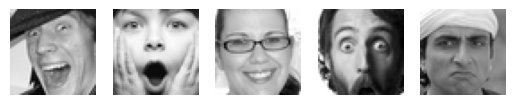

In [52]:
# Display visualisation of previously selected samples
fig, axs = plt.subplots(1, len(samples))
for i in range(0, len(samples)):
  # Transform str value in 'pixels' column into 48x48 numeric matrix
  pixel_matrix = np.array(samples.iloc[:, 1].values[i].split(' '), dtype=int).reshape(48, 48)
  # Print image
  axs[i].imshow(pixel_matrix, cmap='gray')
  axs[i].axis('off')
plt.show()

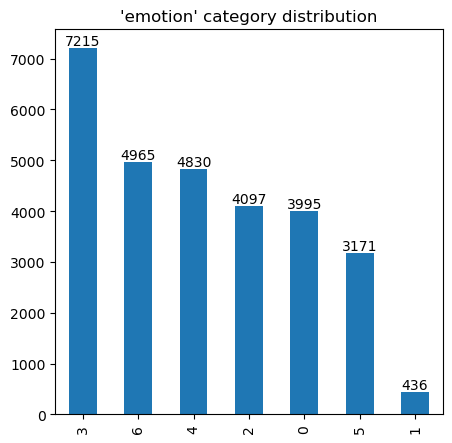

In [53]:
# Create pyplot to show distribution of data in the dataset
fig, ax = plt.subplots(1, 1, figsize=(5,5))
# Display distribution of 'emotion' category
dataset.iloc[:, 0].value_counts().plot(kind='bar', ax=ax, title='\'emotion\' category distribution')
a = ax.bar_label(ax.containers[0])

- The dataset has class imbalance in 'emotion' category;
- The dataset requieres such strategies as class weighting or other to prevent the model bias caused by the class imbalance.

## Data Preprocessing

#### Dataset splitting

In [54]:
# Split the dataset into training and evaluation sets
# Apply stratificaton to make sure both train and evaluation sets the same category distribution
train_set, eval_set = train_test_split(dataset, test_size=0.2, random_state=0, stratify=dataset.emotion)
# Reset sets indexes, or will get errors during the training phase
train_set = train_set.reset_index(drop=True)
eval_set = eval_set.reset_index(drop=True)

#### Dataset Weights Sampling

In [55]:
# Due to dataset class imbalance generate sample weights for training set
# get amount of samples in each category
class_counts = dict(train_set.emotion.value_counts())
# create sample weights
sample_weights = [1.0 / class_counts[w] for w in train_set.emotion]
# Create weighted sampler
weighted_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

#### Custom PyTorch Dataset

In [56]:
# Prepare custom PyTorch Dataset class for train and test sets
class FER_Dataset(Dataset):
  def __init__(self, data, transform=None):
      # for image convert str values into 1x48x48 matrixes
      self.images = data.iloc[:, 1].apply(lambda x: np.array(x.split(' '), dtype=np.uint8).reshape(-1, 48, 48))
      self.images = tuple([torch.tensor(x) for x in self.images])
      self.labels = data.iloc[:, 0]
      self.labels = tuple([torch.tensor(x) for x in self.labels])
      self.transform = transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      image = self.images[idx]
      label = self.labels[idx]

      if self.transform:
          image = self.transform(image)

      return image, label

## Data Augmentation

The project uses torchvision.transforms.v2 for data augmentation due to their better performance

#### Calculate Mean and Std of all pixels

In [57]:
# For v2.Normalise transformer, calculate all pixels mean and standart deviation
pixels = dataset.pixels.apply(lambda x: np.array(x.split(' '), dtype=np.uint8).reshape(-1)) / 255.0
pixels = np.concatenate(pixels)
print('Mean:',pixels.mean())
print('Std:', pixels.std())

Mean: 0.5077425080522147
Std: 0.25500891562522027


#### Initiate Transformers

In [58]:
# Transformer for training set with data augmentation
transformer_train = v2.Compose([
  v2.RandomHorizontalFlip(p=0.5),         # 50% to flip horisontally
  v2.RandomAffine(degrees=8,              # Randomly rotated up to 8 angle        
                  translate=(0.2, 0.2),   # Randomly shifts by x or y up to 20%
                  scale=(0.8, 1.2)),      # Randomly scales in range 20%
  v2.ToDtype(torch.float32, scale=True),  # Transfrom into float32 tensor scaled to [0, 1]
  v2.Normalize((0.5077,), (0.2550,)),     # Normalise image
])

# Transformer for test set
transformer_test = v2.Compose([
  v2.ToDtype(torch.float32, scale=True),  # Transfrom into float32 tensor scaled to [0, 1]
  v2.Normalize((0.5077,), (0.2550,)),     # Normalise image
])

## Model Development

#### Custom Resudial CNN network

The model uses Residual CNN structure

In [59]:
# Basic Residual Block class
class ResidualBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int) -> None:
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.LeakyReLU()
    self.identity_downsample = None
    if in_channels != out_channels:
      self.identity_downsample = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels))

  def forward(self, x: Tensor) -> Tensor:
    identity = self.identity_downsample(x) if self.identity_downsample else x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x += identity
    x = self.relu(x)

    return x

In [60]:
# Create custom Residual CNN Class
class EmotionRecognitionCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Inititian conv layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding='same', bias=False), 
            nn.BatchNorm2d(16), 
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Residual layers
        self.layer1 = nn.Sequential(
            ResidualBlock(16, 32),
            ResidualBlock(32, 32),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2, 2),
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2)
        )
        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 3 * 3, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2048, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

#### Weights Initialisation function

In [61]:
# Create weights initialisation strategy
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        init.zeros_(m.bias)

#### Create Model

In [62]:
# Create a model, send to GPU and initiate weights
model = EmotionRecognitionCNN(7)
model = model.to('cuda')
_ = model.apply(initialize_weights)

#### Initiate loss function, optimisation, and LR strategy

In [63]:
# Define loss function CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# Define optimisation Adam
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Define learning rate strategy
sheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=10, factor=0.5, threshold=0.001)

## Model Training and Evaluation

#### Custom Functions

In [64]:
# Function that trains model
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [65]:
# Function that evaluates model
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), correct / total

In [66]:
# Function to build confusion matrix
def show_confusion_matrix(model, dataloader, device):
  classes=['0', '1', '2', '3', '4', '5', '6']
  model.eval()  # Set the model to evaluation mode

  all_preds = []
  all_true = []

  # Predict values
  with torch.no_grad():  
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, preds = torch.max(outputs, 1) 

          all_preds.extend(preds.view(-1).cpu().numpy())
          all_true.extend(labels.view(-1).cpu().numpy())

  # Print accuracy score
  accuracy = accuracy_score(all_true, all_preds)
  print(f'Accuracy: {accuracy*100:.2f}%')
  
  # Construct the confusion matrix
  cm = confusion_matrix(all_true, all_preds)
  # Normalise values
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # Build plot
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in np.ndindex(cm.shape):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.show()

In [67]:
# Function that builds plots for performance metrics
def plot_performance_metrics(metric1, metric2, metric3, metric4):
    metric_names=['Train Loss', 'Test Loss', 'Accuracy', 'Learning Rate']
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of plots
    axs = axs.ravel()  # Flatten the array of axes

    metrics = [metric1, metric2, metric3, metric4]
    
    for i, metric in enumerate(metrics):
        axs[i].plot(metric)
        axs[i].set_title(metric_names[i])
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(metric_names[i])
    
    plt.tight_layout()
    plt.show()

### Training

#### Create DataLoaders

In [68]:
# Create dataloaders for train and evaluation sets
train_loader = DataLoader(FER_Dataset(train_set, transform=transformer_train), 
                          batch_size=256, sampler=weighted_sampler)
eval_loader = DataLoader(FER_Dataset(eval_set, transform=transformer_test),
                         batch_size=256)
# Device to use
device = 'cuda'

#### Load model weights from file (Uncomment to use)

In [75]:
checkpoint = None
# Uncomment lines below to download weights from file
# checkpoint = torch.load('my_model_weights_v3_348.pth')
# model.load_state_dict(checkpoint['weigths'])

<All keys matched successfully>

#### Initiate metrics for plots

In [70]:
# Initiate metrics arrays
m_epochs = checkpoint['m_epochs'] if checkpoint else []
m_tr_loss = checkpoint['m_tr_loss'] if checkpoint else []
m_te_loss = checkpoint['m_te_loss'] if checkpoint else []
m_acc = checkpoint['m_acc'] if checkpoint else []
m_lr = checkpoint['m_lr'] if checkpoint else []

#### Start training process

In [71]:
# Uncomment to Set new learning rage
# optimizer.param_groups[0]['lr'] = 0.0000001
# Num of epochs per session
num_epochs = 1000

# Start training 
start_time = time.time()
max_epochs = len(m_epochs) + num_epochs
for epoch in range(len(m_epochs), max_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, eval_loader, criterion, device)
    end_time = time.time()

    m_epochs.append(epoch)
    m_tr_loss.append(train_loss)
    m_te_loss.append(test_loss)
    m_acc.append(accuracy)
    m_lr.append(optimizer.param_groups[0]['lr']) 

    print(f"Epoch [{epoch+1}/{max_epochs}],\
    Train Loss: {train_loss:.4f},\
    Test Loss: {test_loss:.4f},\
    Acc: {accuracy:.4f},\
    Time(s): {end_time - start_time:.1f}, \
    Lr: {optimizer.param_groups[0]['lr']:.7f}")
    sheduler.step(train_loss)

KeyboardInterrupt: 

#### Save data to file

In [72]:
# Save data uncomment to save model weights
# data_dict = {
#   'weigths': model.state_dict(),
#   'm_epochs': m_epochs,
#   'm_tr_loss': m_tr_loss, 
#   'm_te_loss': m_te_loss,
#   'm_acc': m_acc,
#   'm_lr': m_lr
# }
# torch.save(data_dict, f'my_model_weights_v3_{m_epochs[-1]}.pth')

### Evaluation

#### Download Test set

In [73]:
# Download test sets extracted from fer2013.csv
test_set = pd.read_csv('./datasets/test.csv')
test_loader = DataLoader(FER_Dataset(test_set, transform=transformer_test),
                         batch_size=256)

#### Confusion matrix

Evaluation Set:
Accuracy: 58.62%


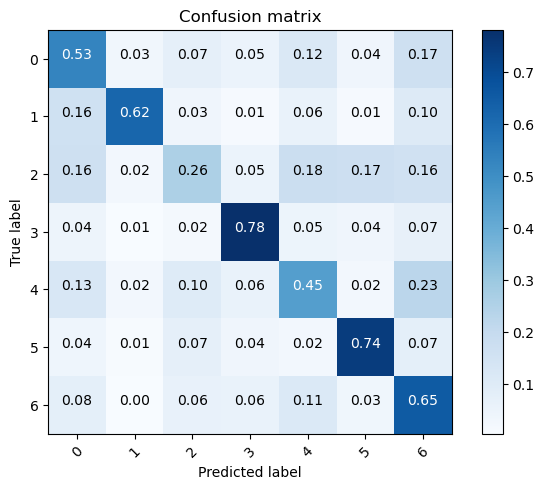

Test Set:
Accuracy: 59.00%


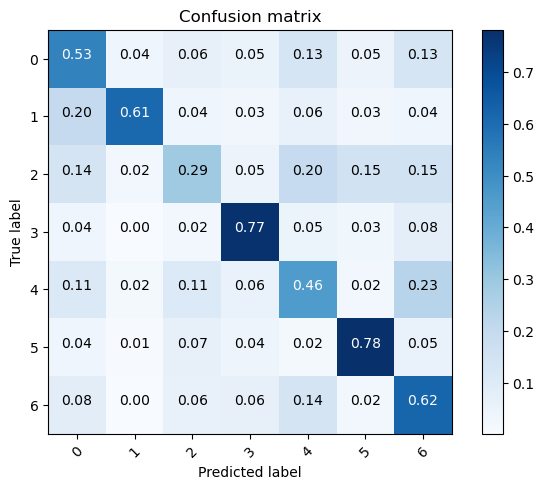

In [76]:
# Print confusion matrix for evaluation set
print('Evaluation Set:')
show_confusion_matrix(model, eval_loader, device)
# Print confusion matrix for test set
print('Test Set:')
show_confusion_matrix(model, test_loader, device)

#### Performance Metrics

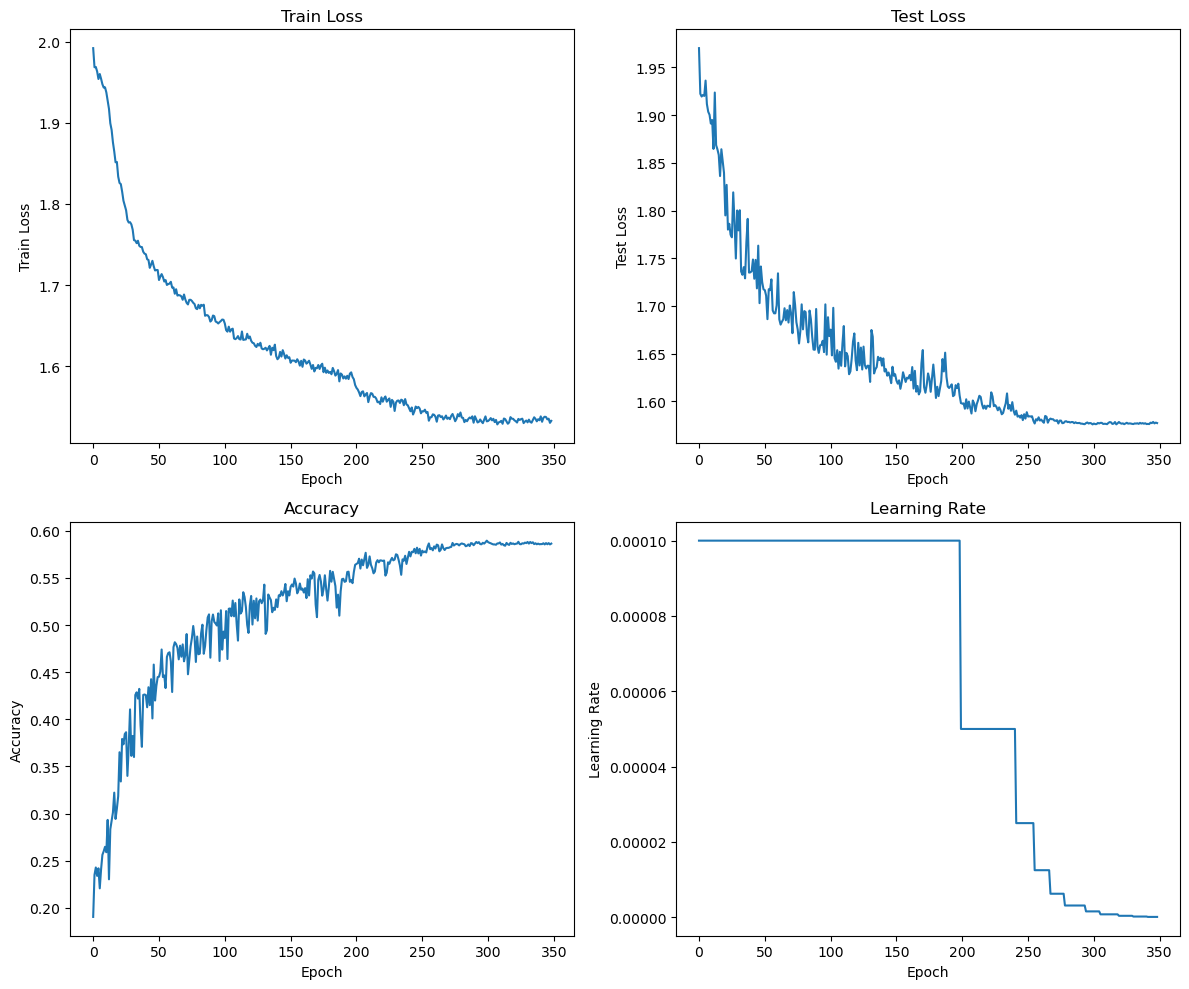

In [77]:
plot_performance_metrics(m_tr_loss, m_te_loss, m_acc, m_lr)

#### Grad-CAM

#### Custom functions

In [78]:
def apply_grad_cam(model, input_image, target_layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    h_forward = target_layer.register_forward_hook(forward_hook)
    h_backward = target_layer.register_full_backward_hook(backward_hook)

    # Forward pass
    output = model(input_image)
    model.zero_grad()

    # Get the index of the max log-probability (predicted class)
    pred_class = output.argmax(dim=1)

    # Backward pass
    pred_class_loss = output[:, pred_class].sum()
    pred_class_loss.backward()

    # Get the gradient and activation
    gradient = gradients[0].detach().cpu().numpy()[0]
    activation = activations[0].detach().cpu().numpy()[0]

    # Global Average Pooling of gradients
    weights = gradient.mean(axis=(1, 2), keepdims=True)

    # Weighted sum of activation maps
    grad_cam_map = np.sum(weights * activation, axis=0)

    # ReLU on heatmap
    grad_cam_map = np.maximum(grad_cam_map, 0)

    # Normalize heatmap
    grad_cam_map = grad_cam_map / (grad_cam_map.max() + 1e-10)

    # Remove hooks
    h_forward.remove()
    h_backward.remove()

    return grad_cam_map

In [79]:
def show_grad_cam_sample():
  # Set model in evaluation mode
  model.eval()
  # Create plot
  fig, axs = plt.subplots(2,3)
  # Extract visualise and convert in Tensor one sample
  pixel_matrix = np.array(dataset.sample(1).pixels.values[0].split(' '), dtype=np.uint8).reshape(1, 1, 48, 48)
  axs[0,0].imshow(pixel_matrix.reshape(48,48), cmap='gray')
  axs[0,0].set_title('Image')
  axs[0,0].axis('off')

  pixel_matrix = torch.tensor(pixel_matrix).to('cuda')
  pixel_matrix = transformer_test(pixel_matrix)

  # Build grad_cam maps for each layer
  grad_cam_map_conv1 = apply_grad_cam(model, pixel_matrix, model.conv1)
  grad_cam_map_layer1 = apply_grad_cam(model, pixel_matrix, model.layer1)
  grad_cam_map_layer2 = apply_grad_cam(model, pixel_matrix, model.layer2)
  grad_cam_map_layer3 = apply_grad_cam(model, pixel_matrix, model.layer3)

  # Visualise them
  axs[0,1].imshow(grad_cam_map_conv1, cmap='jet')
  axs[0,1].set_title('Conv1')
  axs[0,1].axis('off')
  axs[0,2].imshow(grad_cam_map_layer1, cmap='jet')
  axs[0,2].set_title('Layer1')
  axs[0,2].axis('off')
  axs[1,0].imshow(grad_cam_map_layer2, cmap='jet')
  axs[1,0].set_title('Layer2')
  axs[1,0].axis('off')
  axs[1,1].imshow(grad_cam_map_layer3, cmap='jet')
  axs[1,1].set_title('Layer3')
  axs[1,1].axis('off')
  axs[1,2].axis('off')
  plt.show(axs[1,1])

#### Visualise Grad-CAM using random sample

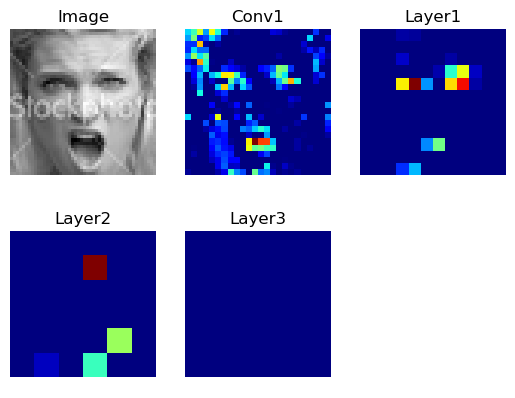

In [80]:
# Draw sample
show_grad_cam_sample()

## Utils

#### Show model summary in TensorBoard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(model, pixel_matrix)
writer.close()

#### Print Model Layout

In [81]:
# Print model layout in text format
from torchsummary import summary
_ = summary(model, (1, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 16, 48, 48]          144
|    └─BatchNorm2d: 2-2                  [-1, 16, 48, 48]          32
|    └─LeakyReLU: 2-3                    [-1, 16, 48, 48]          --
|    └─MaxPool2d: 2-4                    [-1, 16, 24, 24]          --
├─Sequential: 1-2                        [-1, 32, 12, 12]          --
|    └─ResidualBlock: 2-5                [-1, 32, 24, 24]          --
|    |    └─Sequential: 3-1              [-1, 32, 24, 24]          4,672
|    |    └─Conv2d: 3-2                  [-1, 32, 24, 24]          4,608
|    |    └─BatchNorm2d: 3-3             [-1, 32, 24, 24]          64
|    |    └─LeakyReLU: 3-4               [-1, 32, 24, 24]          --
|    |    └─Conv2d: 3-5                  [-1, 32, 24, 24]          9,216
|    |    └─BatchNorm2d: 3-6             [-1, 32, 24, 24]          64
|    